# 2D pca

In [1]:
import imageio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression,  ElasticNet
from sklearn import svm


path_orig = '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/train/aligned/'
path_test = '/mnt/ncshare/ai4covid_hackathon/preprocessed_data/test/aligned/'

df_test = pd.read_csv('/mnt/ncshare/ai4covid_hackathon/preprocessed_data/tables/testClinData.csv')
df_train = pd.read_csv('/mnt/ncshare/ai4covid_hackathon/preprocessed_data/tables/trainClinData.csv')

isSevere = df_train['Prognosis']=='SEVERE'


# Image
img_flat = []
for id in df_train['ImageFile'].values:
     im = imageio.imread(path_orig + id)
     img_flat.append(im.flatten())
img_flat = np.array(img_flat)

img_flat_test = []
for id in df_test['ImageFile'].values:
     im = imageio.imread(path_test + id)
     img_flat_test.append(im.flatten())
img_flat_test = np.array(img_flat_test)

nTrain = len(img_flat)
nTest = len(img_flat_test)




In [2]:
# PCA
U2,S2,V2 = la.svd(np.concatenate([img_flat,img_flat_test]),full_matrices=False)

In [8]:
#np.random.seed(42)
#rnd_idx = np.random.permutation( U2.shape[0] )

array([1079,  405, 1492, ...,  860, 1459, 1126])

In [12]:
isSevere

0        True
1       False
2       False
3       False
4        True
        ...  
1098     True
1099    False
1100     True
1101     True
1102     True
Name: Prognosis, Length: 1103, dtype: bool

In [13]:
X_train = U2[:nTrain]
y_train = isSevere.values
X_test = U2[nTrain:]

In [16]:
rr = 293767
#X_train, X_test, y_train, y_test = train_test_split(
#    U2[:nTrain], isSevere, random_state=rr
#)


# Crossval regression for train
clf = LogisticRegression(solver='saga',penalty='elasticnet',l1_ratio=1,max_iter=500,random_state=rr)
# Fit
clf.fit(X_train, y_train)
# Predict
preds = clf.predict(X_test)
# Score
#a = accuracy_score(y_test, preds)


# Feature importance
importance = clf.coef_[0]


#print("accuracy:",a)


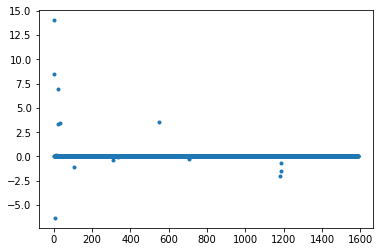

In [17]:
plt.plot([x for x in range(len(importance))], (importance),'.')

In [18]:
importance[np.abs(importance)>0]

array([ 8.4577694e+00,  1.4024175e+01, -6.3442965e+00,  1.2316499e-01,
        3.2930267e+00,  6.9339309e+00,  3.3967383e+00, -1.0613437e+00,
       -4.0564293e-01, -1.1437527e-01,  3.5072768e+00, -8.6535886e-03,
       -1.3040125e-01, -2.9603592e-01,  2.5143992e-02, -2.0702767e+00,
       -1.5029068e+00, -7.2209144e-01], dtype=float32)

In [19]:
nImportant = sum(np.abs(importance)>0)
print(nImportant)

idxImportant = np.flipud(np.abs(importance).argsort()[-nImportant:])
print(idxImportant)

18
[   2    1   23    4  547   33   21 1179 1185  103 1188  308  707  704
   13  334  820  560]


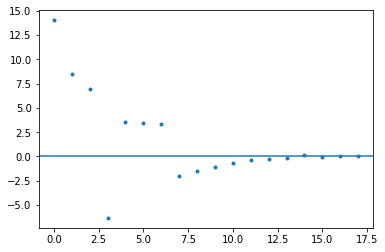

In [20]:
plt.plot(importance[idxImportant],'.')
plt.axhline(0)

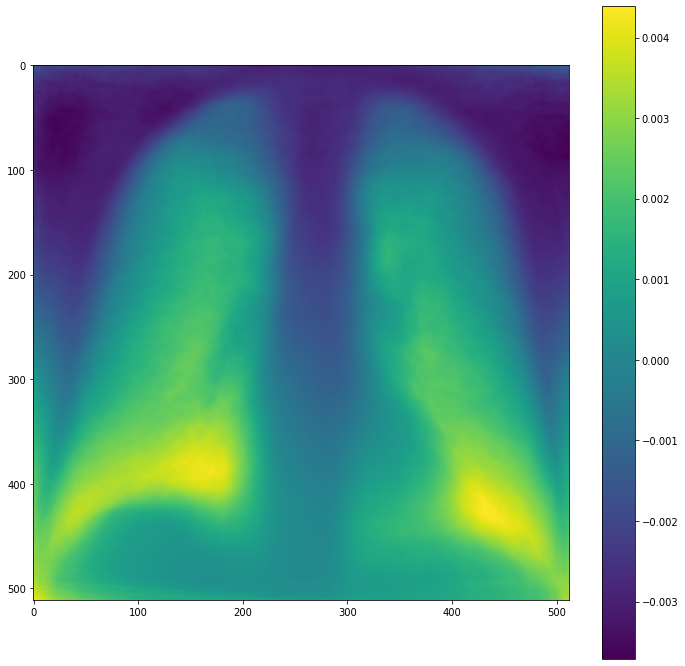

In [21]:
plt.figure(figsize=[12,12])
plt.imshow(V2[2].reshape([512,512]))
plt.colorbar()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


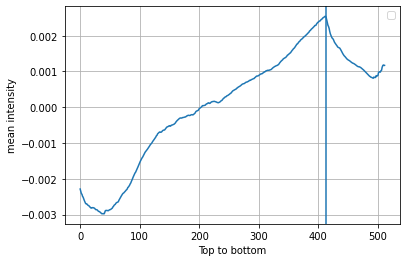

In [22]:
#plt.plot(V2[2].reshape([512,512]).mean(axis=1))
_ = np.median(V2[2].reshape([512,512]),axis=1)
plt.plot(_)
plt.xlabel('Top to bottom')
plt.ylabel('mean intensity')
plt.legend()
plt.axvline(_.argmax())
plt.grid()

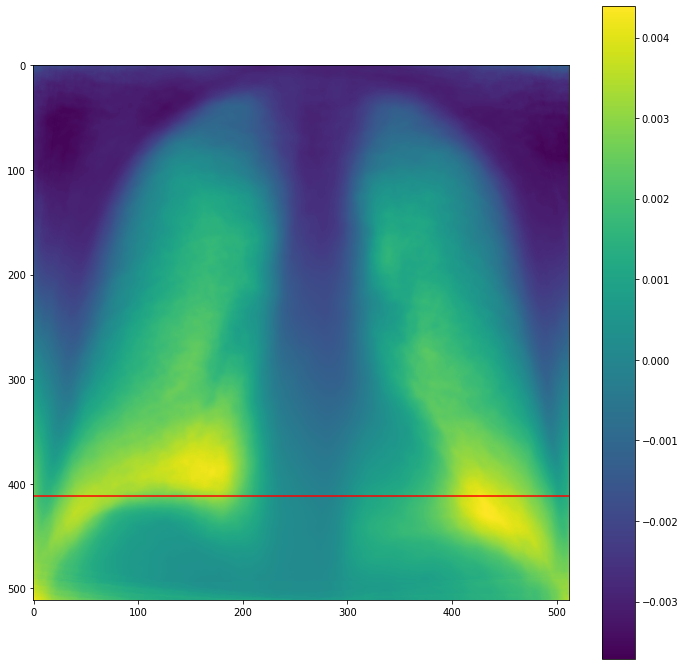

In [23]:
plt.figure(figsize=[12,12])
plt.imshow(V2[2].reshape([512,512]))
plt.axhline(_.argmax(),c='r')
plt.colorbar()

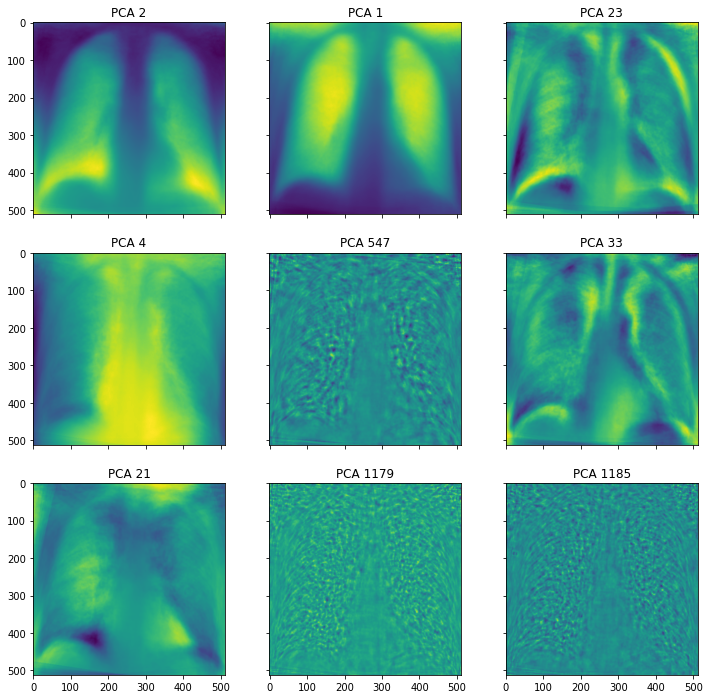

In [24]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=[12,12])

sig = np.sign(importance[idxImportant])

c = 0
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(sig[c]*V2[idxImportant[c]].reshape([512,512]))
        axs[i,j].set_title("PCA "+str(idxImportant[c]))
        c += 1



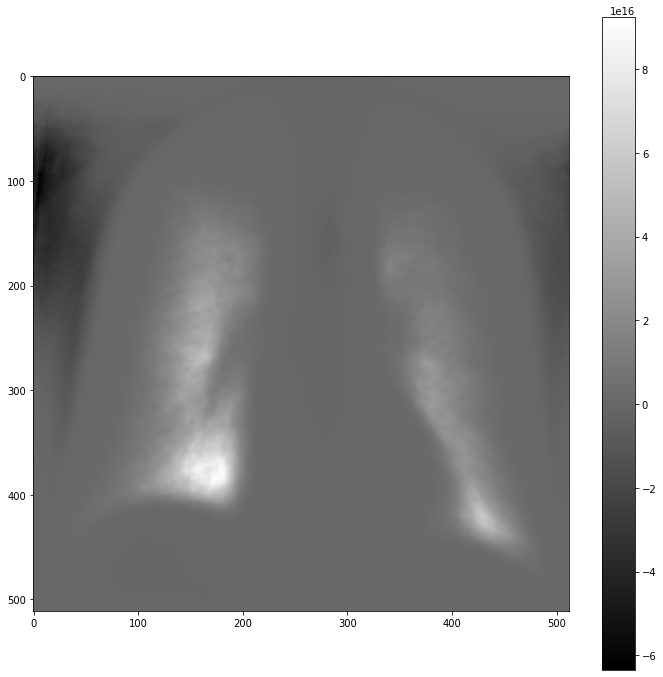

In [25]:
weighted = np.zeros([512,512])
for i,idx in enumerate(idxImportant):
    weighted += importance[idx]*S2[idx]*V2[idx].reshape([512,512])

plt.figure(figsize=[12,12])
#plt.imshow(weighted)
plt.imshow(np.sign(weighted)*np.abs(weighted)**4,cmap='gray')
plt.colorbar()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


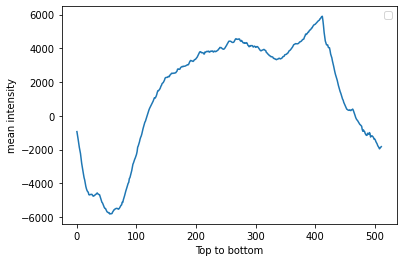

In [26]:
_ = np.median(weighted,axis=1)
plt.plot(_)
plt.xlabel('Top to bottom')
plt.ylabel('mean intensity')
plt.legend()

### Parameters for test and train

In [56]:
destination_path = '../data/preprocessed_data/tables/'

In [48]:
columns = [ "pca_coef_"+str(i) for i in range( len(idxImportant) ) ]

In [49]:
test_df_feature = pd.DataFrame( U2[nTrain:,idxImportant], columns=columns )
test_df_feature.insert( 0, "ImageFile", df_test.ImageFile )

In [57]:
test_df_feature.to_csv( destination_path+'pca_coefs_test.csv', index=False )

In [51]:
train_df_feature = pd.DataFrame( U2[:nTrain,idxImportant], columns=columns )
train_df_feature.insert( 0, "ImageFile", df_train.ImageFile )

In [58]:
train_df_feature.to_csv( destination_path+'pca_coefs_train.csv', index=False )

In [53]:
U2[:nTrain,idxImportant].shape

(1103, 18)